In [2]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 

#Style Settings
sns.set(rc = {'axes.facecolor':'white'
              ,'figure.figsize':(12,8)
              ,'figure.facecolor':'white'
              ,'axes.edgecolor': '#C4C4BF'
              ,'lines.linewidth':3
              ,'axes.titlesize':26
              ,'axes.labelsize':16
              ,'axes.labelcolor':'black'
              ,'grid.color': '#EEEEED'
              ,'text.color':'black'
              ,'xtick.color':'black'
              ,'ytick.color':'black'
              ,'ytick.labelsize':14
              ,'xtick.labelsize':14
              ,'legend.fontsize':12
              ,'axes.linewidth':2
              ,'grid.linestyle': '--'},
            font = 'Segoe UI')

In [3]:
training_data_df = pd.read_csv('../data/train.csv')
train, test = train_test_split(training_data_df, test_size=0.2)


X_train = train.drop(columns= ['label']).to_numpy().T 
y_train = train['label'].to_numpy()

X_test = test.drop(columns= ['label']).to_numpy().T 
y_test = test['label'].to_numpy()

# Create an instance of StandardScaler
scaler = StandardScaler()

# Normalize the matrix X column-wise
normalized_X = scaler.fit_transform(X_train)

In [20]:
class neural_network:



    def __init__(self, hidden_layers: int, node_counts: list):

        # Number of hidden layers 
        self.hidden_layers = hidden_layers
        if type(self.hidden_layers) != int:
            raise ValueError('hidden_layers must be an integer')
        
        # Number of nodes in each hidden layer
        self.node_counts = node_counts
        if type(self.node_counts) != list:
            raise ValueError('node_counts must be a list with length = hidden_layers')
        

        # Check if length of nodes_array matches the number of hidden_layers
        if hidden_layers != len(node_counts):
            raise ValueError('Number of hidden layers must match number of node counts')
        

    # Activation Functions

    # Relu
    def relu(self,x):
        return np.maximum(0,x)
    
    # Relu Derivative
    def relu_deriv(self,Z):
        return Z > 0

    # Leaky Relu
    def leaky_relu(self,x):
        return np.where(x > 0, x, x * 0.01)

    # Leaky Relu Derivative
    def leaky_relu_deriv(self,x):
        return np.where(x > 0, 1, 0.01)
        
    # Tanh
    def tanh(self,x):
        return np.tanh(x)

    def sech(self,x):
        return 1 / np.cosh(x)

    # Tanh Derivative
    def tanh_deriv(self,x ):

        return self.sech(x)**2
        
    # Sigmoid
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    # Sigmoid Derivative
    def sigmoid_deriv(self,x):

        return (self.sigmoid(x)) * (1-self.sigmoid(x))
    
    # Softmax function for converting last Z matrix to a probability vector
    def softmax(self,x):
        return np.exp(x) / np.sum(np.exp(x),axis = 0)
    
    # One hot encoding function for classification for target variable
    def ohe(self,y):
    
        one_hot_Y = np.zeros(shape = (y.size, y.max() + 1))
        one_hot_Y[np.arange(y.size), y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y
    
    # Defining Loss Function
    def loss(self,pred, test):

        return ((pred - self.ohe(test))**2).mean()

    # Method for generating predictions. Taking the index with the largest activation which will correspond to the digit prediction
    def get_predictions(self,A2):
        return np.argmax(A2, 0)

    # Method for getting accuracy
    def get_accuracy(self,predictions, Y):
        return np.sum(predictions == Y) / Y.size
    
    # Creating dictionary for activation functions
    
    activation_dict = {'relu':relu
                        ,'leaky_relu':leaky_relu
                        ,'tanh':tanh
                        ,'sigmoid':sigmoid}


    derivative_dict = {'relu':relu_deriv
                            ,'leaky_relu':leaky_relu_deriv
                            ,'tanh':tanh_deriv
                            ,'sigmoid':sigmoid}


    # Intializing Network Parameters
    def init_params(self,X,h1_n, h2_n, input_size):

        #  Weight Matrix centered at zero
        W1 = np.random.rand(h1_n,input_size) - 0.5
        W2 = np.random.rand(h2_n,h1_n) - 0.5

        # Initializing Biases Vectors
        b1 = np.zeros(shape = (h1_n,1))
        b2 = np.zeros(shape = (h2_n,1))

        return W1, b1, W2,b2 


    # Forward Prop
    def forward_prop(self,X, W1, b1, W2, b2,activation = 'relu'):
        
        Z1 = W1.dot(X) + b1
        A1 = self.activation_dict[activation](self,Z1)

        Z2 = W2.dot(A1) +b2
        A2 = self.softmax(Z2)
  
        return Z1, A1, Z2, A2
    
    # Backward Propogation
    def back_prop (self,X, y, W1, Z1, A1, W2, A2,activation = 'relu'):
        m = X.shape[1]

        dZ2 = A2 - self.ohe(y)
        dW2 = (1/m) * np.dot(dZ2,A1.T)
        db2 = (1/m) * np.sum(dZ2)

        dZ1 = np.dot(W2.T,dZ2) * self.derivative_dict[activation](self,Z1)
        dW1 = (1/m) * np.dot(dZ1,X.T)
        db1 = (1/m) * np.sum(dZ1)


        return dW1, db1, dW2, db2
    
    # Param Update
    def updated_params(self,W1,dW1, W2,dW2, b1, db1, b2, db2, learning_rate = 1 ):
        W2 = W2 - (learning_rate * dW2)
        b2 = b2 - (learning_rate * db2)

        W1 = W1 - (learning_rate * dW1)
        b1 = b1 - (learning_rate * db1)
        return W1, b1, W2 , b2
    
    # Gradient Descent

    def fit(self,X,y,activation, learning_rate = 0.1, epochs = 1000 ):

        W1, b1, W2, b2 = self.init_params(X,self.node_counts[0],self.node_counts[0],X.shape[0])
        accuracy_array = []
        epoch_array = []
        for i in range(epochs):
            Z1, A1, Z2, A2 = self.forward_prop(X, W1, b1, W2, b2, activation)
            dW1, db1, dW2, db2 = self.back_prop (X, y, W1, Z1, A1, W2, A2,activation)
            W1, b1, W2, b2 = self.updated_params(W1,dW1, W2,dW2, b1, db1, b2, db2, learning_rate = learning_rate)

            # Doing one more forward prop for last run
            if i == (epochs - 1):
                Z1, A1, Z2, A2 = self.forward_prop(X, W1, b1, W2, b2,activation)
            predictions = self.get_predictions(A2)
            accuracy = self.get_accuracy(predictions, y)

            accuracy_array.append(accuracy)
            if i % 10 == 0:
                    print(f"Iteration {i}: Accuracy: {accuracy} ")


        
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2 
        self.b2 = b2
        self.accuracy_array = accuracy_array


    def predict(self,X,y ):
        a = self.forward_prop(X, self.W1, self.b1, self.W2, self.b2)
        return a[3].argmax(axis = 0)





In [21]:
lr = 0.2

# Running NN
nn = neural_network(hidden_layers = 2,node_counts= [10,10] )
e = 1_000
nn.fit(X = normalized_X, y = y_train , activation = 'tanh',learning_rate = lr, epochs = e)
tanh_acc = nn.accuracy_array

# Running NN
nn = neural_network(hidden_layers = 2,node_counts= [10,10] )
e = 1_000
nn.fit(X = normalized_X, y = y_train , activation = 'relu',learning_rate = lr, epochs = e)
relu_acc = nn.accuracy_array

# Running NN
nn = neural_network(hidden_layers = 2,node_counts= [10,10] )
e = 1_000
nn.fit(X = normalized_X, y = y_train , activation = 'sigmoid',learning_rate = lr, epochs = e)
sigmoid_acc = nn.accuracy_array

# Running NN
nn = neural_network(hidden_layers = 2,node_counts= [10,10] )
e = 1_000
nn.fit(X = normalized_X, y = y_train , activation = 'leaky_relu',learning_rate = 0.3, epochs = e)
leaky_relu_acc = nn.accuracy_array

Iteration 0: Accuracy: 0.09711309523809523 
Iteration 10: Accuracy: 0.18583333333333332 
Iteration 20: Accuracy: 0.26321428571428573 
Iteration 30: Accuracy: 0.34330357142857143 
Iteration 40: Accuracy: 0.4107440476190476 
Iteration 50: Accuracy: 0.46910714285714283 
Iteration 60: Accuracy: 0.5098214285714285 
Iteration 70: Accuracy: 0.5411607142857143 
Iteration 80: Accuracy: 0.5673809523809524 
Iteration 90: Accuracy: 0.5866964285714286 
Iteration 100: Accuracy: 0.6055357142857143 
Iteration 110: Accuracy: 0.6201488095238096 
Iteration 120: Accuracy: 0.6355059523809524 
Iteration 130: Accuracy: 0.6508630952380953 
Iteration 140: Accuracy: 0.6755357142857142 
Iteration 150: Accuracy: 0.6875892857142857 
Iteration 160: Accuracy: 0.6998214285714286 
Iteration 170: Accuracy: 0.7124107142857142 
Iteration 180: Accuracy: 0.7225297619047619 
Iteration 190: Accuracy: 0.7305952380952381 
Iteration 200: Accuracy: 0.7388988095238095 
Iteration 210: Accuracy: 0.7459821428571428 
Iteration 220: A

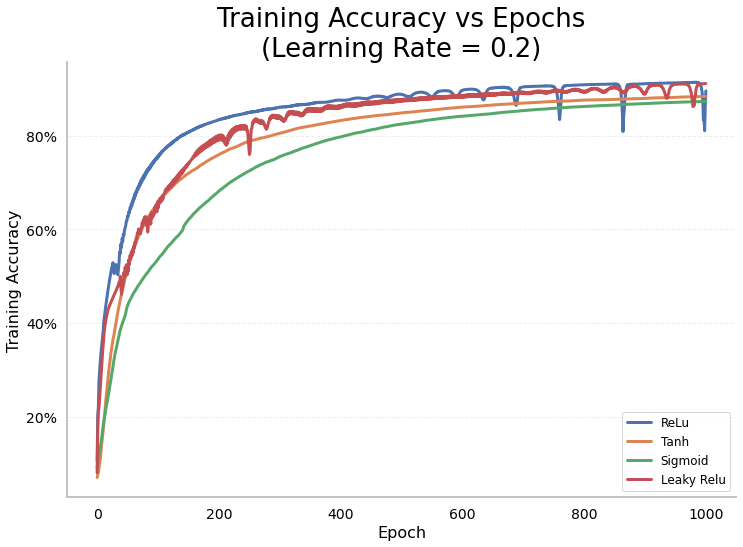

In [60]:
# Plotting Accuracy over Epochs
acc = nn.accuracy_array

fig,ax = plt.subplots()
sns.lineplot(x = range(e), y = relu_acc,label = 'ReLu')
sns.lineplot(x = range(e), y = tanh_acc, label = 'Tanh')
sns.lineplot(x = range(e), y = sigmoid_acc,label = 'Sigmoid')
sns.lineplot(x = range(e), y = leaky_relu_acc,label = 'Leaky Relu')


plt.title(f'Training Accuracy vs Epochs\n(Learning Rate = {lr})')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
sns.despine(top = True, right = True, left = False, bottom = False)
ax.xaxis.grid(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals= 0))

In [61]:
# Predicting on Test Dataset
X_test_scaled = scaler.fit_transform(X_test)

test_accuracy = nn.get_accuracy(nn.predict(X_test_scaled,y_test),y_test)
train_accuracy =nn.get_accuracy(nn.predict(normalized_X,y_train),y_train)

print(f'Test Accuracy: {test_accuracy}\nTrain Accuracy: {train_accuracy}')

Test Accuracy: 0.9001190476190476
Train Accuracy: 0.9090178571428571
